In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score


In [25]:
try:
    from google.colab import files
    uploaded = files.upload()
    # Assuming uploaded file name is 'housePrice.csv'
    data_read = pd.read_csv("housePrice.csv")
except ImportError:
    # If not in Colab, just read from local disk
    data_read = pd.read_csv("housePrice.csv")

Saving housePrice.csv to housePrice (3).csv


In [27]:
data = data_read.drop(columns=['Price(USD)'])
data['Area'] = data['Area'].str.replace(',', '').astype(float)
data['Room'] = data['Room'].astype(int)

target_col = 'Price'
X = data.drop(columns=[target_col])
y = data[target_col]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [28]:
target_col = 'Price'
X = data.drop(columns=[target_col])
y = data[target_col]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), make_column_selector(dtype_include="number")),
    ("cat", OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=["object", "bool"]))
])

pipeline = Pipeline([('preprocessor', preprocessor)])

# Fit only on training data
pipeline.fit(X_train)

# Transform features
X_train_processed = pipeline.transform(X_train)
X_test_processed = pipeline.transform(X_test)

# If output is sparse matrix, convert to dense
if hasattr(X_train_processed, "toarray"):
    X_train_processed = X_train_processed.toarray()
    X_test_processed = X_test_processed.toarray()

# Scale targets
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Convert to tensors and send to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [29]:

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

# Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=False
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

In [30]:
class LinReg(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


Epoch 1/100 | Train Loss: 1.0210 | Train R2: -0.0210 | Test Loss: 0.7253 | Test R2: -0.0450
Epoch 2/100 | Train Loss: 0.9526 | Train R2: 0.0474 | Test Loss: 0.5832 | Test R2: 0.1597
Epoch 3/100 | Train Loss: 0.6336 | Train R2: 0.3664 | Test Loss: 0.3233 | Test R2: 0.5343
Epoch 4/100 | Train Loss: 0.4716 | Train R2: 0.5284 | Test Loss: 0.2751 | Test R2: 0.6037
Epoch 5/100 | Train Loss: 0.3981 | Train R2: 0.6019 | Test Loss: 0.2786 | Test R2: 0.5986
Epoch 6/100 | Train Loss: 0.3713 | Train R2: 0.6287 | Test Loss: 0.2407 | Test R2: 0.6532
Epoch 7/100 | Train Loss: 0.3466 | Train R2: 0.6534 | Test Loss: 0.2530 | Test R2: 0.6355
Epoch 8/100 | Train Loss: 0.3295 | Train R2: 0.6705 | Test Loss: 0.2274 | Test R2: 0.6724
Epoch 9/100 | Train Loss: 0.3302 | Train R2: 0.6698 | Test Loss: 0.2293 | Test R2: 0.6697
Epoch 10/100 | Train Loss: 0.3297 | Train R2: 0.6703 | Test Loss: 0.2625 | Test R2: 0.6218
Epoch 11/100 | Train Loss: 0.3254 | Train R2: 0.6746 | Test Loss: 0.2477 | Test R2: 0.6431
Epoch 

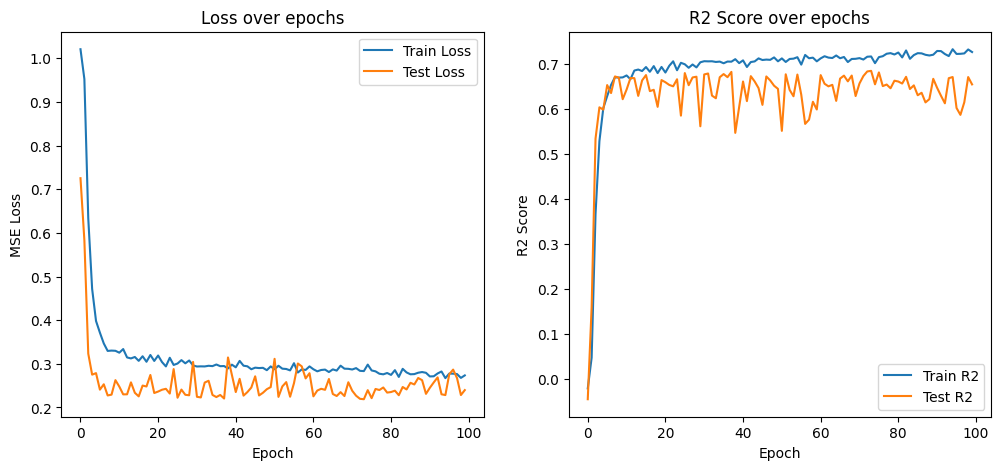

In [33]:

model = LinReg(input_dim=X_train_tensor.shape[1]).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100

train_losses = []
test_losses = []
train_r2s = []
test_r2s = []

for epoch in range(n_epochs):
    model.train()
    train_loss_epoch = 0
    train_preds = []
    train_targets = []
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item() * X_batch.size(0)
        train_preds.append(y_pred.detach().cpu().numpy())
        train_targets.append(y_batch.detach().cpu().numpy())

    train_loss_epoch /= len(train_dataset)
    train_losses.append(train_loss_epoch)

    train_preds = np.vstack(train_preds)
    train_targets = np.vstack(train_targets)
    train_r2 = r2_score(train_targets, train_preds)
    train_r2s.append(train_r2)

    model.eval()
    test_loss_epoch = 0
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            test_loss_epoch += loss.item() * X_batch.size(0)

            test_preds.append(y_pred.cpu().numpy())
            test_targets.append(y_batch.cpu().numpy())

    test_loss_epoch /= len(test_dataset)
    test_losses.append(test_loss_epoch)

    test_preds = np.vstack(test_preds)
    test_targets = np.vstack(test_targets)
    test_r2 = r2_score(test_targets, test_preds)
    test_r2s.append(test_r2)

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"Train Loss: {train_loss_epoch:.4f} | Train R2: {train_r2:.4f} | "
          f"Test Loss: {test_loss_epoch:.4f} | Test R2: {test_r2:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Loss over epochs")

plt.subplot(1, 2, 2)
plt.plot(train_r2s, label="Train R2")
plt.plot(test_r2s, label="Test R2")
plt.xlabel("Epoch")
plt.ylabel("R2 Score")
plt.legend()
plt.title("R2 Score over epochs")

plt.show()